# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).

**0. Instalare de librarii si incarcare de date:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

df = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
231,41,Private,130408,HS-grad,9,Divorced,Sales,Unmarried,Black,Female,0,0,38,United-States,<=50K
19344,25,Self-emp-not-inc,72338,HS-grad,9,Never-married,Sales,Unmarried,Asian-Pac-Islander,Female,0,0,40,United-States,<=50K
24410,38,Private,146398,HS-grad,9,Never-married,Other-service,Unmarried,Black,Female,0,0,24,United-States,<=50K
15144,26,Private,250066,Assoc-voc,11,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
11137,51,Private,174754,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Female,0,0,38,United-States,<=50K
1226,36,Private,354078,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
2614,41,Private,304906,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
19541,37,Private,237995,Assoc-voc,11,Divorced,Machine-op-inspct,Not-in-family,Black,Male,0,0,48,United-States,<=50K
16549,35,Private,112512,HS-grad,9,Widowed,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K
8319,50,Private,22418,9th,5,Divorced,Transport-moving,Not-in-family,White,Male,0,0,50,United-States,<=50K


**1. Refacerea preprocesarii din Task.1:**

- Deoarece algoritmii de clustering precum K-Means se bazeaza pe distante matematice, este important ca toate datele sa fie la aceeasi scara. Asadar am normalizat totul folosind StandardScaler.
- Am inclus atat variabilele numerice, cat si cele categorice codificate (One-Hot), pentru a prinde nuantele legate de job sau stare civila.


In [3]:
df = df.drop_duplicates()
df = df.dropna() 

df['income_bin'] = df['income'].map({'<=50K': 0, '>50K': 1})

numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week']
categorical_features = ['marital-status', 'occupation', 'sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Transformam datele
X_processed = preprocessor.fit_transform(df)
print(f"Dimensiunea datelor preprocesate: {X_processed.shape}")

Dimensiunea datelor preprocesate: (32537, 26)


**2. Metoda Elbow:**

- Am rulat algoritmul K-Means pentru un numar variabil de clustere (de la 2 la 10) si am calculat cat de imprastiate sunt punctele fata de centrul grupului lor. 
- Unde linia se frange brusc, acolo e punctul optim; echilibrul perfect intre a avea grupuri compacte si a nu avea prea multe grupuri inutile.

Se ruleaza KElbowVisualizer...


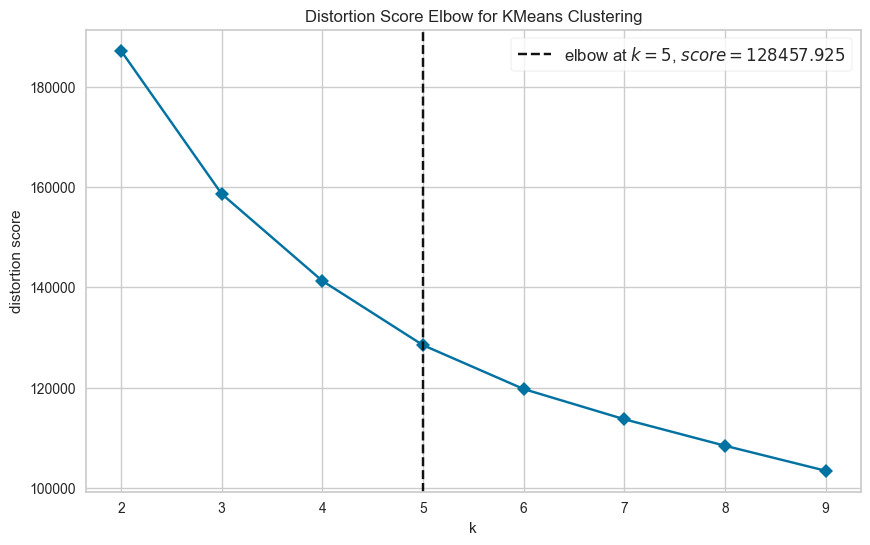

Numarul optim de clustere detectat este: 5


In [4]:
print("Se ruleaza KElbowVisualizer...")
model = KMeans(n_clusters=5, random_state=42, n_init=10)

plt.figure(figsize=(10, 6))
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False, force_model=True)
visualizer.fit(X_processed)        
visualizer.show()                 

optimal_k = visualizer.elbow_value_
if optimal_k is None:
    optimal_k = 3 
print(f"Numarul optim de clustere detectat este: {optimal_k}")

**3. Antrenarea modelului K-Means si Silhouette Score:**

- Dupa ce am decis numarul de clustere, am antrenat modelul final.
- Ca sa verific cat de bune sunt aceste grupuri, am calculat Silhouette Score. 

In [5]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_processed)

df['Cluster'] = cluster_labels

sample_size = 10000
if len(X_processed) > sample_size:
    from sklearn.utils import resample
    X_sample, label_sample = resample(X_processed, cluster_labels, n_samples=sample_size, random_state=42)
    score = silhouette_score(X_sample, label_sample)
else:
    score = silhouette_score(X_processed, cluster_labels)

print(f"Silhouette Score (Calitatea clusterelor): {score:.4f}")

Silhouette Score (Calitatea clusterelor): 0.1466


**4. Vizualizarea Clusterelor in 2D cu PCA:**

- Deoarece datele mele au zeci de dimensiuni din cauza One-Hot Encoding, nu le pot desena pe o foaie. Aici a intrat in scena PCA (Principal Component Analysis). 
- Am redus toate acele dimensiuni la doar doua componente principale care pastreaza cat mai mult din variatia originala. Asta mi-a permis sa fac un scatterplot 2D.
- Am colorat punctele in functie de clusterul din care fac parte, ca sa vad vizual daca s-au separat bine sau daca sunt o masa amorfa.

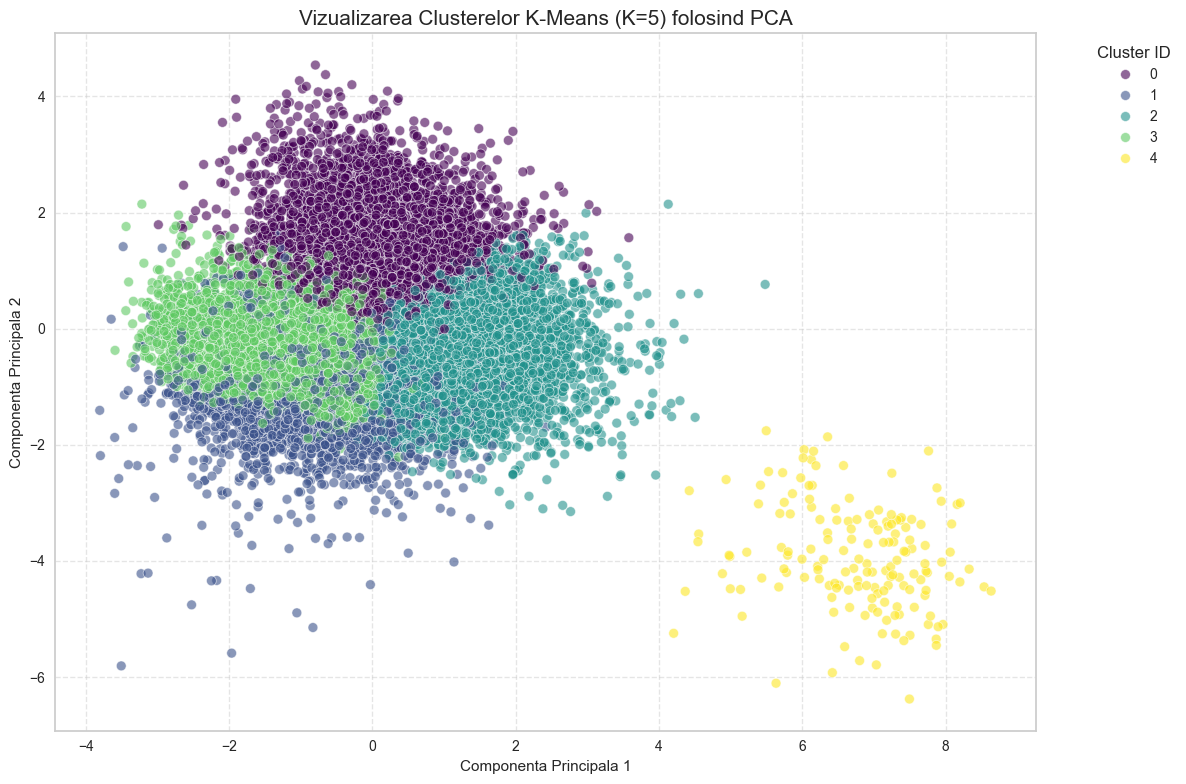

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_processed)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=pca_df,
    palette='viridis',
    s=50, alpha=0.6,
    legend='full'
)
plt.title(f'Vizualizarea Clusterelor K-Means (K={optimal_k}) folosind PCA', fontsize=15)
plt.xlabel('Componenta Principala 1')
plt.ylabel('Componenta Principala 2')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**5. Interpretarea Clusterelor:**

- Am luat variabilele numerice originale (varsta, ore lucrate, etc.) si am calculat media pentru fiecare cluster. Asa am putut sa pun o eticheta umana pe grupuri.
- Boxplot-urile m-au ajutat sa vad distributia exacta a orelor de munca pentru fiecare grup.

--- Profilul Mediu al Clusterelor ---


,Cluster,age,education-num,hours-per-week,capital-gain
0,0,52.570068,8.528451,37.574183,494.827298
1,1,34.361743,9.654573,40.802061,423.784457
2,2,41.386384,12.495604,49.422340,1257.622746
3,3,26.463837,9.437536,34.785535,178.772481
4,4,46.358491,12.918239,49.798742,99999.000000


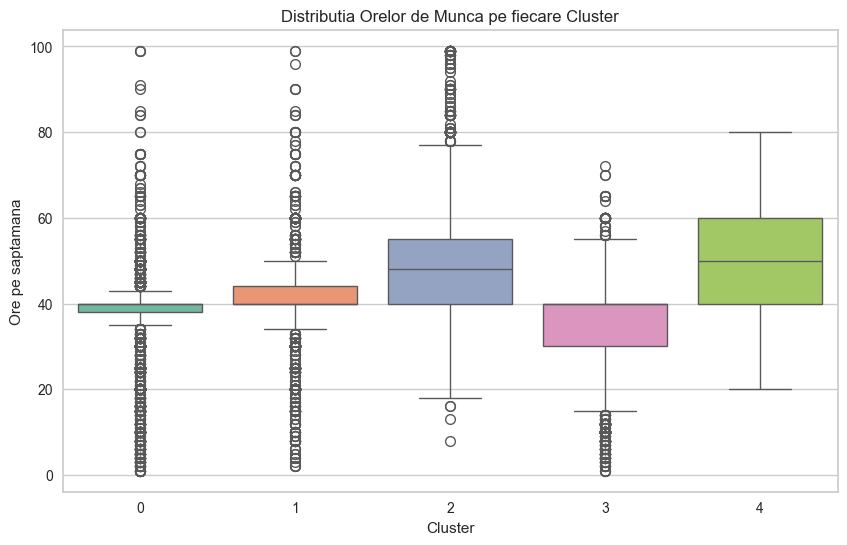

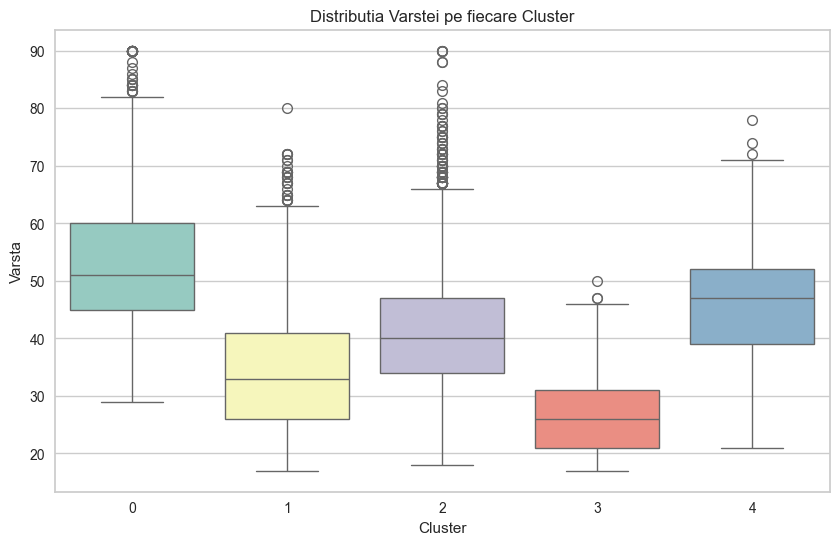

In [7]:
# Analiza caracteristicilor pe fiecare cluster
numerical_analysis = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'Cluster']

cluster_summary = df[numerical_analysis].groupby('Cluster').mean().reset_index()
print("--- Profilul Mediu al Clusterelor ---")
display(cluster_summary)

# Vizualizare distributie Ore de Munca per Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='hours-per-week', data=df, hue='Cluster', palette='Set2', legend=False)
plt.title('Distributia Orelor de Munca pe fiecare Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ore pe saptamana')
plt.show()

# Vizualizare distributie Varsta per Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='age', data=df, hue='Cluster', palette='Set3', legend=False)
plt.title('Distributia Varstei pe fiecare Cluster')
plt.xlabel('Cluster')
plt.ylabel('Varsta')
plt.show()

**6. Alternative: Hierarchical Clustering si DBSCAN**

- Desi K-Means e cel mai solid, am vrut sa vad daca alte metode gasesc structuri diferite.
- Am testat Hierarchical Clustering (care construieste un arbore de grupuri) si DBSCAN (care cauta zone dense de puncte si ignora zgomotul).
- DBSCAN e mai pretentios la parametri (epsilon), dar e singurul care poate spune "aceste puncte sunt zgomot si nu apartin nimanui". Am rulat aceste modele pe un esantion mai mic, deoarece sunt foarte costisitoare computational pe 30.000 de randuri.

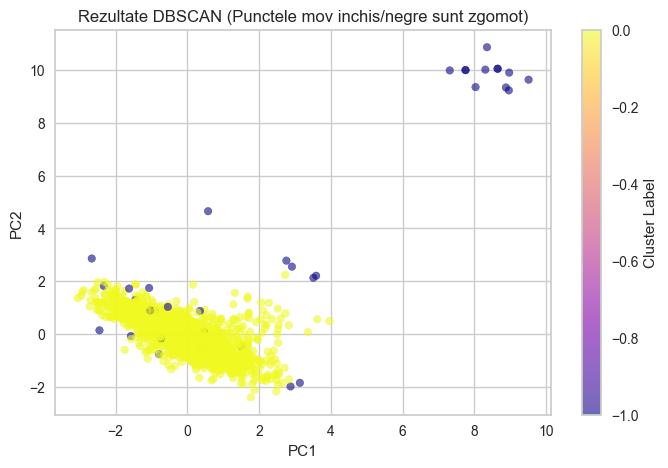

Numar clustere gasite de DBSCAN: 1
Puncte considerate zgomot (noise): 37


In [8]:
# Luam un esantion mic (2000 randuri) pentru clustering ierarhic si DBSCAN (pentru viteza)
X_small, _ = resample(X_processed, cluster_labels, n_samples=2000, random_state=42)

# 1. Hierarchical Clustering (Agglomerative)
agg_model = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_model.fit_predict(X_small)

# 2. DBSCAN
dbscan_model = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_small)

# Vizualizare rapida PCA pentru DBSCAN (pentru a vedea zgomotul)
pca_small = PCA(n_components=2).fit_transform(X_small)
plt.figure(figsize=(8, 5))
plt.scatter(pca_small[:, 0], pca_small[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.6, s=30)
plt.title('Rezultate DBSCAN (Punctele mov inchis/negre sunt zgomot)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.show()

print(f"Numar clustere gasite de DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Puncte considerate zgomot (noise): {list(dbscan_labels).count(-1)}")